In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVC
!pip install catboost
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')


In [52]:
df=pd.read_csv('insurance.csv')
df.sample(5)

,age,sex,bmi,children,smoker,region,charges
183,44,female,26.410,0,no,northwest,7419.47790
309,41,female,33.060,2,no,northwest,7749.15640
615,47,female,36.630,1,yes,southeast,42969.85270
838,35,female,23.465,2,no,northeast,6402.29135
30,22,male,35.600,0,yes,southwest,35585.57600


In [53]:
df.shape

(1338, 7)

## Data Cleaning


Missing values

In [54]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [55]:
df.duplicated().sum()

1

In [56]:
df[df.duplicated()==True]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [57]:
df=df.drop_duplicates()

In [58]:
df.duplicated().sum()

0

In [59]:
df.shape

(1337, 7)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [61]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [62]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [63]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64

removing outliers

<Axes: ylabel='charges'>

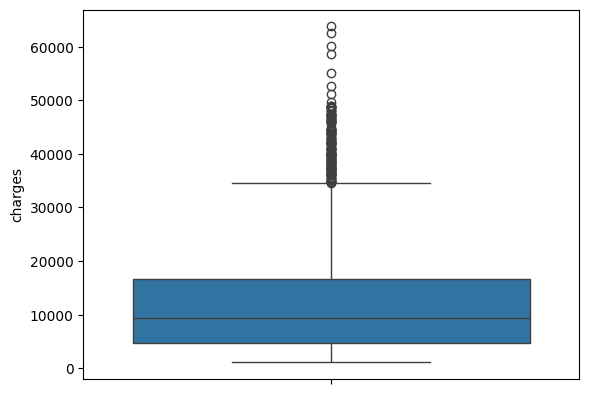

In [64]:
sns.boxplot(df['charges'])

In [65]:
#charges column
# q1=df['charges'].quantile(0.25)
# q3=df['charges'].quantile(0.75)
# iqr=q3-q1
# upper_limit=q3+1.5*iqr
# lower_limit=q1-1.5*iqr

# outliers=(df['charges']<lower_limit) | (df['charges']>upper_limit)
# df=df[~outliers]

In [66]:
df.shape

(1337, 7)

<Axes: ylabel='charges'>

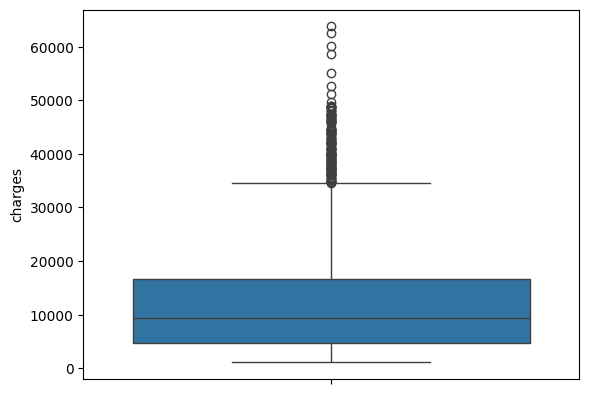

In [67]:
sns.boxplot(df['charges'])

<Axes: ylabel='bmi'>

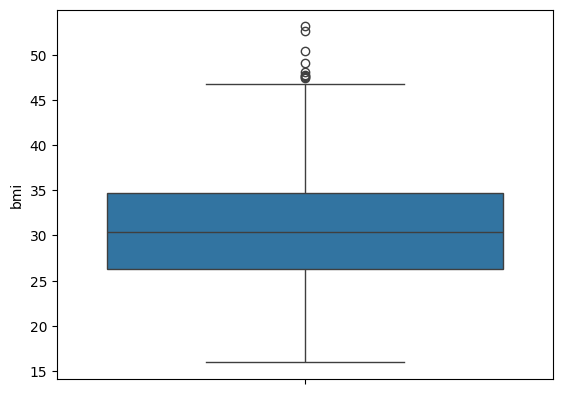

In [68]:
sns.boxplot(df['bmi'])

In [69]:
# # bmi
# q1=df['bmi'].quantile(0.25)
# q3=df['bmi'].quantile(0.75)
# iqr=q3-q1
# upper_limit=q3+1.5*iqr
# lower_limit=q1-1.5*iqr

# outliers=(df['bmi']<lower_limit) | (df['bmi']>upper_limit)
# df=df[~outliers]

In [70]:
df.shape

(1337, 7)

<Axes: ylabel='bmi'>

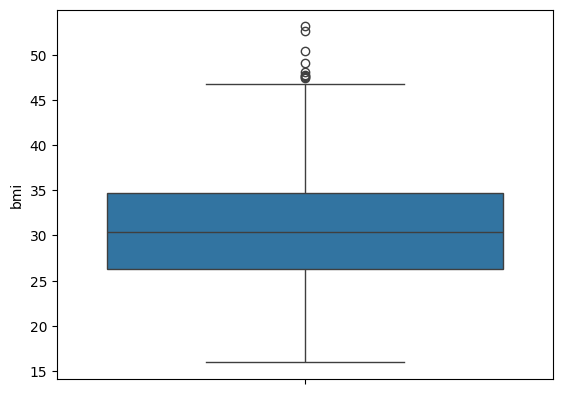

In [71]:
sns.boxplot(df['bmi'])


## Feature Engg


num and cat


In [72]:
numerical_features = [feature for feature in df.columns if df[feature].dtype!='O']
categorical_features = [feature for feature in df.columns if df[feature].dtype=='O']
target = "charges"

print('We have {} numerical features : {}'.format(len(numerical_features), numerical_features))
print('We have {} categorical features : {}'.format(len(categorical_features), categorical_features))

print("\nCategories in 'sex' variable:     ",end=" " )
print(df['sex'].unique())

print("Categories in 'smoker' variable:  ",end=" ")
print(df['smoker'].unique())

print("Categories in'region' variable:",end=" " )
print(df['region'].unique())

We have 4 numerical features : ['age', 'bmi', 'children', 'charges']
We have 3 categorical features : ['sex', 'smoker', 'region']

Categories in 'sex' variable:      ['female' 'male']
Categories in 'smoker' variable:   ['yes' 'no']
Categories in'region' variable: ['southwest' 'southeast' 'northwest' 'northeast']


In [73]:
#adding columns
df['age_range']='old'
df.loc[(df['age']<=30) & (df['age']>0), 'age_range']='young'
df.loc[((df['age']>30) & (df['age']<=60)), 'age_range']='middle'
df.loc[(df['age']>60), 'age_range'] ='old'
df.head()

,age,sex,bmi,children,smoker,region,charges,age_range
0,19,female,27.900,0,yes,southwest,16884.92400,young
1,18,male,33.770,1,no,southeast,1725.55230,young
2,28,male,33.000,3,no,southeast,4449.46200,young
3,33,male,22.705,0,no,northwest,21984.47061,middle
4,32,male,28.880,0,no,northwest,3866.85520,middle


In [74]:
# Adding a bmi_range categorical column where bmi <18.5 falls under underweight range, 18.5 - 24.9 falls under normal range, 25.0 - 29.9 falls under overweight range, and >30.0 falls under obese range
df['bmi_range'] = 'normal'

for i in range(len(df)):
    if df['bmi'].iloc[i] < 18.5:
        df['bmi_range'].iloc[i] = 'underweight'
    elif df['bmi'].iloc[i] > 25.0 and df['bmi'].iloc[i] < 29.9:
        df['bmi_range'].iloc[i] = 'overweight'
    elif df['bmi'].iloc[i] > 30.0:
        df['bmi_range'].iloc[i] = 'obese'
    else:
        df['bmi_range'].iloc[i] = 'normal'

df.head()




# df.loc[(df['bmi'] < 18.5), 'bmi_range'] = 'underweight'
# df.loc[(df['bmi'] > 25.0) & (df['bmi'] < 29.9), 'bmi_range'] = 'overweight'
# df.loc[(df['bmi'] > 30.0), 'bmi_range'] = 'obese'
# df.head()

,age,sex,bmi,children,smoker,region,charges,age_range,bmi_range
0,19,female,27.900,0,yes,southwest,16884.92400,young,overweight
1,18,male,33.770,1,no,southeast,1725.55230,young,obese
2,28,male,33.000,3,no,southeast,4449.46200,young,obese
3,33,male,22.705,0,no,northwest,21984.47061,middle,normal
4,32,male,28.880,0,no,northwest,3866.85520,middle,overweight


## Modelling



In [75]:
x=df.drop(['age', 'bmi', 'charges'],axis=1)
y=df['charges']

In [76]:
numerical_features = [feature for feature in x.columns if x[feature].dtype!='object']
categorical_features = [feature for feature in x.columns if x[feature].dtype=='object']
preprocessor = ColumnTransformer([
    ('one_hot_encoder', OneHotEncoder(), categorical_features),
    ('standard_scaler', StandardScaler(), numerical_features)
])

In [77]:
print(numerical_features)
print(categorical_features)

['children']
['sex', 'smoker', 'region', 'age_range', 'bmi_range']


In [78]:
x_trans=preprocessor.fit_transform(x)

In [79]:
x_train,x_test,y_train,y_test=train_test_split(x_trans,y,test_size=0.2,random_state=42)
x_train.shape,x_test.shape

((1069, 16), (268, 16))

In [80]:
# model training
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    r2 = r2_score(true, predicted)
    rmse = np.sqrt(mse)
    return mae, mse, r2, rmse

models={
    'LinearRegression':LinearRegression(),
    'Ridge':Ridge(),
    'Lasso':Lasso(),
    'DecisionTreeRegressor':DecisionTreeRegressor(),
    'RandomForestRegressor':RandomForestRegressor(),
    'AdaBoostRegressor':AdaBoostRegressor(),
    'XGBRegressor':XGBRegressor(),
    'CatBoostRegressor':CatBoostRegressor(verbose=False),
    'KNeighborsRegressor':KNeighborsRegressor()
}
model_list=[]
r2_list=[]

for i in range(len(list(models))):
    model=list(models.values())[i]
    model.fit(x_train,y_train)
    #Make Predictions
    y_pred=model.predict(x_test)
    mae, mse, r2, rmse=evaluate_model(y_test,y_pred)
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Testing set')
    print("- Root Mean Squared Error: {:.4f}".format(rmse))
    print("- Mean Absolute Error: {:.4f}".format(mae))
    print("- R2 Score: {:.4f}".format(r2))
    r2_list.append(r2)

    print('='*35)
    print('\n')

LinearRegression
Model performance for Testing set
- Root Mean Squared Error: 6423.5280
- Mean Absolute Error: 4787.4856
- R2 Score: 0.7755


Ridge
Model performance for Testing set
- Root Mean Squared Error: 6481.7425
- Mean Absolute Error: 4800.2876
- R2 Score: 0.7714


Lasso
Model performance for Testing set
- Root Mean Squared Error: 6480.6881
- Mean Absolute Error: 4800.2618
- R2 Score: 0.7714


DecisionTreeRegressor
Model performance for Testing set
- Root Mean Squared Error: 5094.1920
- Mean Absolute Error: 3188.4851
- R2 Score: 0.8588


RandomForestRegressor
Model performance for Testing set
- Root Mean Squared Error: 4920.4296
- Mean Absolute Error: 3101.6934
- R2 Score: 0.8682


AdaBoostRegressor
Model performance for Testing set
- Root Mean Squared Error: 5169.3980
- Mean Absolute Error: 3921.6493
- R2 Score: 0.8546


XGBRegressor
Model performance for Testing set
- Root Mean Squared Error: 5176.8691
- Mean Absolute Error: 3334.5910
- R2 Score: 0.8542


CatBoostRegressor
Mod

In [81]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2 Score']).sort_values(by=['R2 Score'], ascending=False)


,Model Name,R2 Score
4,RandomForestRegressor,0.868246
7,CatBoostRegressor,0.865424
3,DecisionTreeRegressor,0.858776
5,AdaBoostRegressor,0.854575
6,XGBRegressor,0.854155
8,KNeighborsRegressor,0.795600
0,LinearRegression,0.775454
2,Lasso,0.771440
1,Ridge,0.771365


In [86]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
score = r2_score(y_test, y_pred)

print("Accuracy of the model is", score)

Accuracy of the model is 0.8691560657984074


Text(0, 0.5, 'Predicted')

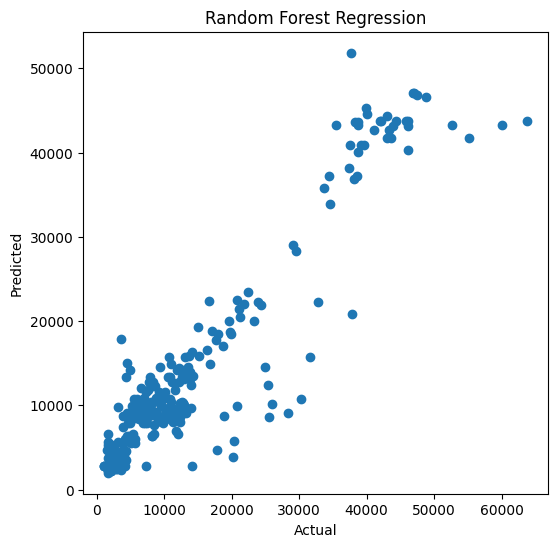

In [95]:
plt.figure(figsize=(6,6))
plt.scatter(y_test,y_pred)

plt.title('Random Forest Regression')
plt.xlabel('Actual')
plt.ylabel('Predicted')